In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import time
import datetime

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

## set working dir

In [5]:
import os
os.chdir("../data")
print (os.getcwd())

/home/cbleker/Reddit-Analysis/data


In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [81]:
def load_data(path, dates_D):
    reddit_ids = []
    data = []
    with open(path, 'r', newline='\n') as f:
        for line in f:
            reddit_id, comments = line.split('\t', maxsplit=1)
            if reddit_id in dates_D.keys():
                data.append(comments)
                reddit_ids.append(reddit_id)
    return reddit_ids, data

In [82]:
def load_dates(path):
    dates_D = {}
    with open(path, 'r', newline='\n') as f:
        for line in f:
            reddit_id, field = line.strip().split('\t', maxsplit=1)
            dates_D[reddit_id] = field
    return dates_D

In [83]:
flat_comments_file = './worldnews_2017_1-2017_1_flatcomments.txt'
submission_dates_file = './worldnews_2017_1-2017_1_submissiondates.txt'

## read comments and dates

In [84]:
dates = load_dates(submission_dates_file)
reddit_ids, data_samples = load_data(flat_comments_file, dates)

In [53]:
print (len(data_samples), len(dates))

609 831


In [54]:
n_features = 1000
n_components = 10
n_top_words = 20
n_samples = len(data_samples)

In [55]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))

Extracting tf-idf features for NMF...
done in 5.164s.


In [56]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time.time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))
print()

Extracting tf features for LDA...
done in 5.482s.



In [57]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time.time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=609 and n_features=1000...
done in 2.394s.


In [58]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):
Topic #0: trump obama president election hillary clinton vote intelligence donald putin america party politics american voted executive political democrats republicans republican
Topic #1: russia russian ukraine putin nato russians crimea war troops military syria sanctions poland nuclear soviet propaganda eu europe assad nukes
Topic #2: israel palestinians palestinian israeli palestine jews jerusalem jewish hamas arabs arab israelis land gaza peace bank state war west terrorist
Topic #3: china chinese war taiwan trade korea india japan nuclear military sea coal south north countries power pakistan nukes economy japanese
Topic #4: mexico wall mexican border trade trump nafta immigration immigrants illegal american america economy jobs goods pay manufacturing drugs canada americans
Topic #5: money tax income pay taxes work company wage jobs rich companies wealth government job welfare paid economy minimum workers market
Topic #6: eu uk brexit trade

In [59]:
tfidf.shape

(609, 1000)

In [60]:
H = nmf.components_; H.shape

(10, 1000)

In [61]:
W = nmf.fit_transform(tfidf); W.shape

(609, 10)

In [114]:
nmf.reconstruction_err_ # I dont' know if this is a good error or not...

18.234554713085256

## NMF model
NMF model is based on finding $W$ and $H$ that minimises:

$$ ||X - WH||_{F} $$

In this case:

$X_{609 \times 1000} $ is the matrix of samples (comments from a submission) by features (words)

$W_{609 \times10}$ is the matrix of samples to topics, and 

$H_{10 \times 1000}$ is matrix of topics to features  

Also a bunch of other stuff I don't understand yet...

## Order W by date

In [109]:
index = pd.MultiIndex.from_tuples(tuples=[(reddit_id, dates[reddit_id]) for reddit_id in reddit_ids], names=['submission_id', 'Date'])

In [126]:
W_df = pd.DataFrame(W,index=index)
W_df.head()

,,0,1,2,3,4,5,6,7,8,9
submission_id,Date,,,,,,,,,,
5rbsxo,2017-01-31,0.000000,0.000000,0.000000,0.000000,0.030415,0.015396,0.0,0.00000,0.000000,0.107855
5rb1qz,2017-01-31,0.107570,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.27954,0.076388,0.073246
5rb19r,2017-01-31,0.000000,0.234170,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.049535
5rajnd,2017-01-31,0.069141,0.234009,0.000000,0.000014,0.000000,0.000000,0.0,0.00000,0.000000,0.107403
5ra6c3,2017-01-31,0.000000,0.003182,0.362028,0.000756,0.000000,0.000000,0.0,0.00000,0.000000,0.049318


In [127]:
W_df.sort_index(inplace=True)

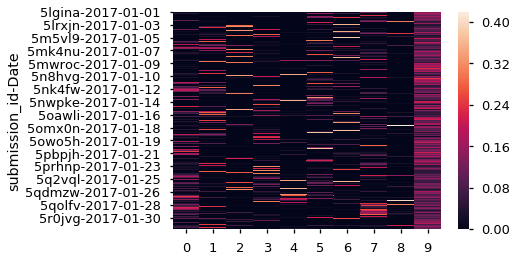

In [128]:
with sns.plotting_context('talk'):
    sns.heatmap(W_df)

In [129]:
topic_per_date = (W_df>0).groupby('Date').sum()

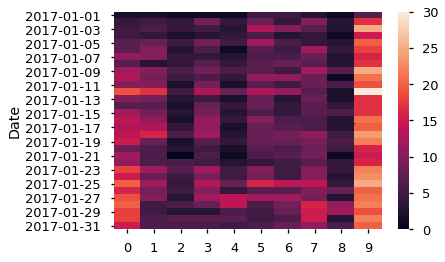

In [130]:
with sns.plotting_context('talk'):
    sns.heatmap(topic_per_date)

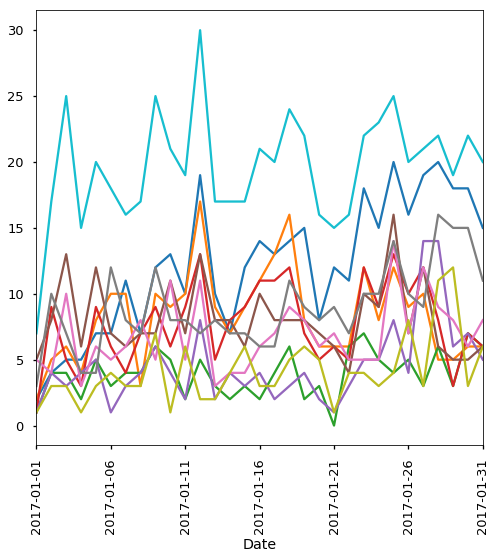

In [124]:
with sns.plotting_context('talk'):
    topic_per_date.plot(figsize=(8.0,8.0),rot=90,legend=False)

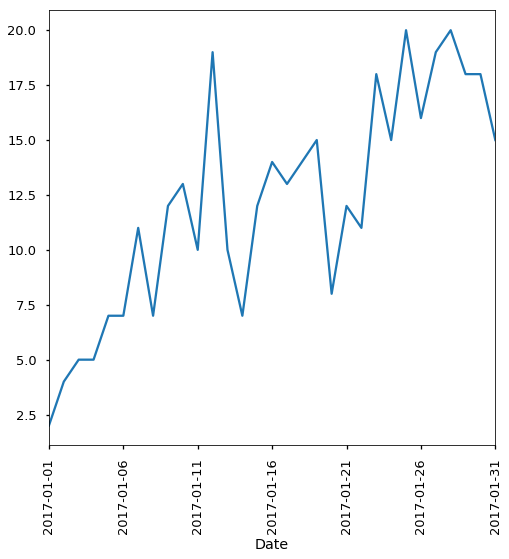

In [125]:
with sns.plotting_context('talk'):
    topic_per_date[0].plot(figsize=(8.0,8.0),rot=90,legend=False)